In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pickle
from catboost import CatBoostClassifier
import pandas as pd
from sqlalchemy import create_engine

def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":  # проверяем где выполняется код в лмс, или локально. Немного магии
        MODEL_PATH = '/workdir/user_input/model'
    else:
        MODEL_PATH = path
    return MODEL_PATH

def load_models():
    from_file = CatBoostClassifier()
    # LOAD MODEL HERE PLS :)
    loaded_model = from_file.load_model(get_model_path("catboost_model"))
    return loaded_model

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [4]:
feed_data_limit = 500000
user_data_limit = 163205#114903 163205
post_text_limit = 7023#6924 7023

In [5]:
%%time
from sklearn.decomposition import PCA 
user_data = batch_load_sql(f"SELECT * FROM public.user_data LIMIT {user_data_limit}")
user_data = user_data.iloc[user_data.drop('user_id', axis=1).drop_duplicates().index.tolist()]

CPU times: user 927 ms, sys: 106 ms, total: 1.03 s
Wall time: 7.28 s


In [6]:
from category_encoders import BinaryEncoder

one_hot_columns = ['gender', 'os', 'exp_group', 'source']
dummies = pd.get_dummies(user_data[one_hot_columns].astype(object))
user_data[dummies.columns.to_list()] = dummies


binary_encoder = BinaryEncoder(cols=['age', 'city'])
new_data = binary_encoder.fit_transform(user_data[['age', 'city']])
user_data = pd.concat([user_data, new_data], axis = 1)

user_data = user_data.drop(['gender', 'exp_group', 'os', 'source', 'country', 'city', 'age'], axis=1)
user_data

,user_id,gender_0,gender_1,os_Android,os_iOS,exp_group_0,exp_group_1,exp_group_2,exp_group_3,exp_group_4,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,200,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,201,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,202,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,203,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,204,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163197,168545,0,1,0,1,0,0,0,0,1,...,0,0,1,0,1,1,1,1,1,1
163198,168546,0,1,1,0,0,0,0,0,1,...,1,1,0,0,1,1,0,0,0,0
163200,168548,1,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,1,0
163202,168550,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0


In [7]:
%%time
post_text = batch_load_sql(f"SELECT * FROM public.post_text_df LIMIT {post_text_limit}")
post_text = post_text.iloc[post_text.drop('post_id', axis=1).drop_duplicates().index.tolist()].dropna()

CPU times: user 56.3 ms, sys: 9.05 ms, total: 65.3 ms
Wall time: 4.78 s


In [8]:
#test
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(post_text['text'])

tfidf_tokens = vectorizer.get_feature_names_out()

post_text['tf_idf'] = pd.DataFrame(
    data=X.toarray(), 
    index=[i for i in range(X.shape[0])], 
    columns=tfidf_tokens
).sum(axis=1)

from category_encoders import BinaryEncoder

one_hot_columns = ['topic']
dummies = pd.get_dummies(post_text[one_hot_columns].astype(object))
post_text[dummies.columns.to_list()] = dummies

In [9]:
from sklearn.preprocessing import StandardScaler

post_text = post_text.dropna().drop('topic', axis=1)

scaler = StandardScaler()
scaler.fit(post_text['tf_idf'].to_frame())
post_text['tf_idf'] = scaler.transform(post_text['tf_idf'].to_frame())

In [10]:
post_text

,post_id,text,tf_idf,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,1,UK economy facing major risks\n\nThe UK manufa...,0.636116,1,0,0,0,0,0,0
1,2,Aids and climate top Davos agenda\n\nClimate c...,1.500018,1,0,0,0,0,0,0
2,3,Asian quake hits European shares\n\nShares in ...,1.708770,1,0,0,0,0,0,0
3,4,India power shares jump on debut\n\nShares in ...,-0.153408,1,0,0,0,0,0,0
4,5,Lacroix label bought by US firm\n\nLuxury good...,-0.211511,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6919,7209,"As a flying and war movie buff, this ranks at ...",0.081229,0,0,0,1,0,0,0
6920,7211,Back in the day if Marion Davies had had her d...,0.135183,0,0,0,1,0,0,0
6921,7212,"...because 99 out of 100 times, the producers ...",-0.335422,0,0,0,1,0,0,0
6922,7213,This is just one of those films which cannot j...,0.043898,0,0,0,1,0,0,0


In [11]:
%%time
feed_data = batch_load_sql(f"SELECT * FROM public.feed_data LIMIT {feed_data_limit}")

feed_data

CPU times: user 2.02 s, sys: 152 ms, total: 2.17 s
Wall time: 13.4 s


,timestamp,user_id,post_id,action,target
0,2021-11-23 18:37:35,129013,2142,view,0
1,2021-11-23 18:38:17,129013,1360,view,0
2,2021-11-23 18:40:53,129013,6523,view,0
3,2021-11-23 18:42:49,129013,7299,view,0
4,2021-11-23 18:45:01,129013,2881,view,0
...,...,...,...,...,...
499995,2021-11-24 18:09:01,136438,5004,view,0
499996,2021-11-24 18:09:28,136438,5104,view,0
499997,2021-11-24 18:12:21,136438,5398,view,0
499998,2021-11-24 18:14:19,136438,5534,view,0


In [12]:
df = post_text.merge(feed_data, how='inner', on='post_id').merge(user_data, how='inner', on='user_id')
#df = post_text.merge(user_data, how='cross').merge(feed_data, how='inner', on=['user_id', 'post_id'])

In [13]:
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [14]:
df_copy = df.copy()
df_copy

,post_id,text,tf_idf,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,1,UK economy facing major risks\n\nThe UK manufa...,0.636116,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
1,2381,Welcome back to lockdown. World beeting T&amp;...,-1.384068,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
2,51,China suspends 26 power projects\n\nChina has ...,0.999367,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
3,96,Troubled Marsh under SEC scrutiny\n\nThe US st...,0.496212,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
4,106,German jobless rate at new record\n\nMore than...,0.889561,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345577,5959,"A letter to the guys. I tried guys, I really t...",-0.819743,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,0
345578,6261,The 1930s saw a vogue for documentary films ab...,-0.499058,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,0
345579,6401,"Oh yes, I admit I have made myself guilty of t...",-0.246192,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,0
345580,6664,"Combine good casting, bad writing, good orches...",1.714218,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,0


In [15]:
from torch.utils.data import Dataset
import torch

In [16]:
#df_copy = df_copy.drop(one_hot_columns, axis=1)

In [17]:
#from category_encoders import TargetEncoder
#mean_target_columns = ['city', 'country', 'topic', 'age']
#encoder = TargetEncoder()
#df_copy[mean_target_columns] = encoder.fit_transform(df_copy[mean_target_columns].astype(object), df['target'])

In [18]:
df_copy

,post_id,text,tf_idf,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,1,UK economy facing major risks\n\nThe UK manufa...,0.636116,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
1,2381,Welcome back to lockdown. World beeting T&amp;...,-1.384068,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
2,51,China suspends 26 power projects\n\nChina has ...,0.999367,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
3,96,Troubled Marsh under SEC scrutiny\n\nThe US st...,0.496212,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
4,106,German jobless rate at new record\n\nMore than...,0.889561,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345577,5959,"A letter to the guys. I tried guys, I really t...",-0.819743,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,0
345578,6261,The 1930s saw a vogue for documentary films ab...,-0.499058,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,0
345579,6401,"Oh yes, I admit I have made myself guilty of t...",-0.246192,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,0
345580,6664,"Combine good casting, bad writing, good orches...",1.714218,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,0


In [19]:
df_copy.drop(['timestamp', 'target', 'action', 'post_id', 'user_id'], axis=1)

,text,tf_idf,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,gender_0,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,UK economy facing major risks\n\nThe UK manufa...,0.636116,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
1,Welcome back to lockdown. World beeting T&amp;...,-1.384068,0,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
2,China suspends 26 power projects\n\nChina has ...,0.999367,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
3,Troubled Marsh under SEC scrutiny\n\nThe US st...,0.496212,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
4,German jobless rate at new record\n\nMore than...,0.889561,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345577,"A letter to the guys. I tried guys, I really t...",-0.819743,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0
345578,The 1930s saw a vogue for documentary films ab...,-0.499058,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0
345579,"Oh yes, I admit I have made myself guilty of t...",-0.246192,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0
345580,"Combine good casting, bad writing, good orches...",1.714218,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0


In [20]:
from torch.utils.data import Dataset
df_to_dataset = df_copy.drop(['timestamp', 'action', 'post_id', 'user_id', 'text'], axis=1)
df_to_dataset

,tf_idf,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,target,gender_0,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,0.636116,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
1,-1.384068,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
2,0.999367,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
3,0.496212,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
4,0.889561,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345577,-0.819743,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0
345578,-0.499058,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0
345579,-0.246192,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0
345580,1.714218,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0


In [21]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.labels = torch.tensor(df[['target']].to_numpy().reshape(-1)).float()
        #self.labels = torch.full((df.shape[0], 6924), 0.5)
        self.dataset = torch.tensor(df.drop('target', axis=1).values).float()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx] 

In [22]:
dataset = CustomDataset(df_to_dataset)
dataset.__getitem__(3649)[0].shape

torch.Size([38])

In [23]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.linear1 = nn.Linear(input_size, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, 64)
        self.linear4 = nn.Linear(64, 128)
        self.linear5 = nn.Linear(128, 256)
        self.linear6 = nn.Linear(256, 256)
        self.linear7 = nn.Linear(256, 128)
        self.linear8 = nn.Linear(128, 64)
        self.linear9 = nn.Linear(64, 32)
        self.linear10 = nn.Linear(32, 1)

        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output = self.activation(self.linear1(x))
        output = self.activation(self.linear2(output))
        output = self.activation(self.linear3(output))
        output = self.activation(self.linear4(output))
        output = self.activation(self.linear5(output))
        output = self.activation(self.linear6(output))
        output = self.activation(self.linear7(output))
        output = self.activation(self.linear8(output))
        output = self.activation(self.linear9(output))
        output = self.sigmoid(self.linear10(output))

        return output

In [24]:
#!g1.1
from tqdm import tqdm


def train(model, train_loader) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x.float())
        
        #print(output.shape, y.shape)
        
        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        #_, y_pred = torch.max(output, 1)
        
        #print(torch.max(output, 1))
        
        total += y.size(0)
        correct += (output == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [25]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        
        
        output = model(x.float())

        loss = loss_fn(output, y)

        total_loss += loss.item()

        #_, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (output == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [26]:
#!g1.1
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_stats(
    train_loss,
    valid_loss,
    train_accuracy,
    valid_accuracy,
    title
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    #plt.figure(figsize=(16, 8))

    #plt.title(title + ' accuracy')
    
    #plt.plot(train_accuracy, label='Train accuracy')
    #plt.plot(valid_accuracy, label='Valid accuracy')
    #plt.legend()
    #plt.grid()

    #plt.show()

In [27]:
def whole_train_valid_cycle(model, num_epochs, title, train_loader, valid_loader):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

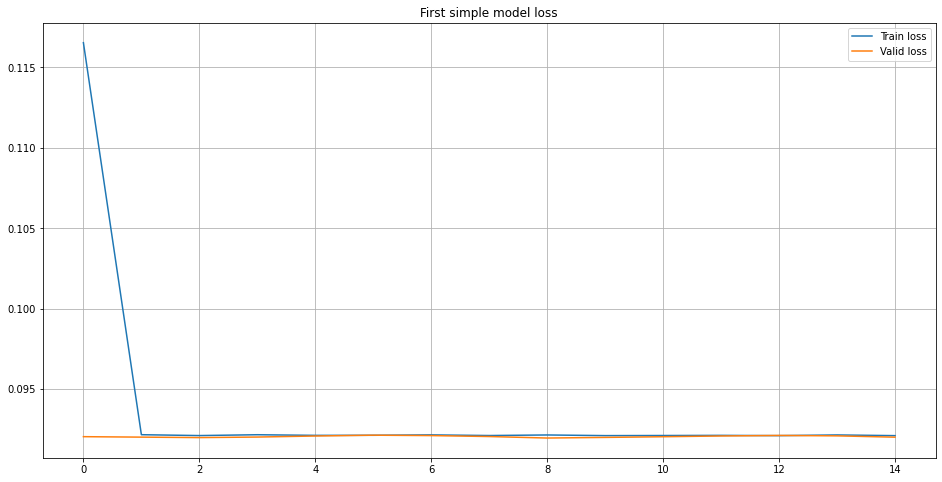

In [28]:
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)


net = Net(df_to_dataset.shape[1] - 1).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_fn = nn.MSELoss() #nn.CrossEntropyLoss()

whole_train_valid_cycle(net, 15, 'First simple model', train_loader, valid_loader)

In [29]:
torch.save(net.state_dict(), 'net')

In [30]:
df_to_dataset.shape[1] - 1

38

In [31]:
loaded_net = Net(df_to_dataset.shape[1] - 1)
loaded_net.load_state_dict(torch.load('net'))
loaded_net = loaded_net.to(device)

In [32]:
test_index_first = 219
test_index_second = 544

test_element_first = df_to_dataset.drop('target', axis=1).iloc[test_index_first]
test_element_second = df_to_dataset.drop('target', axis=1).iloc[test_index_second]

#print(test_element_first)
#print(test_element_second)

test_element_tensor_first = torch.tensor(test_element_first).to(device).float()
test_element_tensor_second = torch.tensor(test_element_second).to(device).float()

#print(test_element_tensor_first)
#print(test_element_tensor_second)

test_result_first = loaded_net(test_element_tensor_first)
test_result_second = loaded_net(test_element_tensor_second)

print(test_result_first)
print(test_result_second)


tensor([0.1086], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.1089], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [33]:
df_to_dataset.drop('target', axis=1).iloc[2011].shape
loaded_net(torch.tensor(df_to_dataset.drop('target', axis=1).iloc[2064].to_frame().T.values).to(device).float())

tensor([[0.1086]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [34]:
#tensor_list = [torch.tensor(df_to_dataset.drop('target', axis=1).iloc[i].to_frame().T.values).to(device).float() for i in range(6023)]

In [35]:
#%time
#results_list = [loaded_net(tensor_list[i]) for i in range(len(tensor_list))]

In [36]:
#results_list.sort(reverse=True)
#results_list

In [37]:
#%%time
#test_to_tensor = df_copy.drop(['user_id', 'post_id', 'timestamp', 'country', 'action', 'target'], axis=1)
#print(torch.tensor(test_to_tensor.iloc[0]))
#print(torch.tensor(test_to_tensor[['text', 'topic']].iloc[0]))
#print(torch.tensor(test_to_tensor.drop(['text', 'topic'], axis=1).iloc[0]))
#torch.cat((torch.tensor(test_to_tensor[['text', 'topic']].iloc[0]), torch.tensor(test_to_tensor.drop(['text', 'topic'], axis=1).iloc[0])))
#user_data

In [38]:
%%time

user_data_limit = 163205

from sklearn.decomposition import PCA 
user_data = batch_load_sql(f"SELECT * FROM public.user_data LIMIT {user_data_limit}")
user_data = user_data.iloc[user_data.drop('user_id', axis=1).index.tolist()]


from category_encoders import BinaryEncoder

one_hot_columns = ['gender', 'os', 'exp_group', 'source']
dummies = pd.get_dummies(user_data[one_hot_columns].astype(object))
user_data[dummies.columns.to_list()] = dummies


binary_encoder = BinaryEncoder(cols=['age', 'city'])
new_data = binary_encoder.fit_transform(user_data[['age', 'city']])
user_data = pd.concat([user_data, new_data], axis = 1)

user_data = user_data.drop(['gender', 'exp_group', 'os', 'source', 'country', 'city', 'age'], axis=1)





post_text = batch_load_sql(f"SELECT * FROM public.post_text_df LIMIT {post_text_limit}")
post_text = post_text.iloc[post_text.drop('post_id', axis=1).drop_duplicates().index.tolist()].dropna()


from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(post_text['text'])

tfidf_tokens = vectorizer.get_feature_names_out()

post_text['tf_idf'] = pd.DataFrame(
    data=X.toarray(), 
    index=[i for i in range(X.shape[0])], 
    columns=tfidf_tokens
).sum(axis=1)

from category_encoders import BinaryEncoder

one_hot_columns = ['topic']
dummies = pd.get_dummies(post_text[one_hot_columns].astype(object))
post_text[dummies.columns.to_list()] = dummies


from sklearn.preprocessing import StandardScaler

post_text = post_text.dropna()

scaler = StandardScaler()
scaler.fit(post_text['tf_idf'].to_frame())
post_text['tf_idf'] = scaler.transform(post_text['tf_idf'].to_frame())

CPU times: user 4.35 s, sys: 2.01 s, total: 6.36 s
Wall time: 19.2 s


In [39]:
df = pd.concat([user_data, post_text])

df

,user_id,gender_0,gender_1,os_Android,os_iOS,exp_group_0,exp_group_1,exp_group_2,exp_group_3,exp_group_4,...,text,topic,tf_idf,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,200.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,202.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,203.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"As a flying and war movie buff, this ranks at ...",movie,0.081229,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Back in the day if Marion Davies had had her d...,movie,0.135183,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"...because 99 out of 100 times, the producers ...",movie,-0.335422,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,This is just one of those films which cannot j...,movie,0.043898,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [41]:
engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )

#df.to_sql('denis21.97@mail.ru_lesson_22', con=engine, if_exists="replace", index=False, method='multi')

In [ ]:
id = 21996
limit = 15
user = df[df['user_id'] == id].dropna(axis=1)
if user.shape[0] == 0:
    user = df.iloc[0].to_frame().T
post_text = df[df['user_id'].isna()].dropna(axis=1)
post_text_tensor = torch.tensor(post_text.drop(['post_id', 'text', 'topic'], axis=1).values)
user_tensor = torch.tensor(user.drop(['user_id'], axis=1).values)

input_tensor = torch.cat((post_text_tensor, user_tensor.repeat(post_text_tensor.shape[0], 1)), 1).to(device)

result = loaded_net(input_tensor.float()).to(device)
result = torch.stack((torch.tensor(post_text['post_id'].values).unsqueeze(1).to(device), result)).squeeze()
result_df = pd.DataFrame(result.squeeze().cpu().detach().numpy()).T
result_df['index'] = result_df[0].astype(int)
sorted_result_df = result_df.set_index('index').drop(0, axis=1).rename(columns={1: 'probs'}).sort_values('probs', ascending=False)
probs_ids = sorted_result_df[:limit].index.values.tolist()
#selected_posts = post_text[post_text.set_index('post_id').index.isin(probs_ids)]

In [ ]:
#test_result = loaded_net.to(device)(torch.tensor(df_to_dataset.drop('target', axis=1).iloc[520]).to(device).float())

#sorted_list = [(i, float(test_result[i])) for i in range(len(test_result))]
#sorted_list.sort(key=lambda x: x[1], reverse=True)
#print(sorted_list)

#a = torch.tensor(df_to_dataset.drop('target', axis=1).iloc[520]).to(device).float()


In [ ]:
user_data